<center>

--- 

# Data Science Project
## Classification of Motor Imagery EEG Signals in Patients with High Uncertainty using a Spectral Transformer
### Jorge de la Rosa, Alejandro del Río
### Bachelor's Degree in Data Science and Artificial Intelligence
<img src=https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/UPM/Logotipo%20con%20Leyenda/LOGOTIPO%20leyenda%20color%20PNG.png width=25% height=25%>

---
</center>

**Description:** The objective of this project is to explore the possibility of using a [spectral transformer](https://www.sciencedirect.com/science/article/abs/pii/S1746809423005633) to classify motor imagery signals in patients where classical methods such as CSP-LDA do not perform well in environments with limited data.

**Note:** The EEGBCI dataset used in the study is available on the [PhysioNet](https://www.physionet.org/content/eegmmidb/1.0.0/) website. This dataset is included in the MNE library. There are several repeated functions throughout the notebook. The important functions are presented in their code the first time, and then they are used through the *utils.py* module for code simplification.

#### Library Import

In [1]:
import numpy as np
import seaborn as sns
import tensorflow as tf
from itertools import combinations
from scipy.signal import welch
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy, categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from mne import Epochs, pick_types, events_from_annotations, set_log_level
from mne.channels import make_standard_montage
from mne.decoding import CSP
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
import matplotlib.pyplot as plt
from tqdm import tqdm

from utils import (
    index_below_threshold,
    display_descriptive_statistics,
    evaluate_and_visualize,
    extract_motor_imagery_data,
    split_eeg_data,
    classify_individual_subjects,
    visualize_csp_components,
    get_BCI_competition_data,
    evaluate_classification_metrics
)

from models import create_ATCNet, create_spectral_transformer_model

# Log configuration
set_log_level('CRITICAL')

# Seaborn configuration
sns.set(style="ticks")

# Disable warnings
import warnings
warnings.filterwarnings("ignore")

# Configuration to display plots in the notebook
%matplotlib inline

### Load data

**Data Extraction for a Given Subject:**
We start by loading the data for Subject No. 1. The sessions used are 6, 10, and 14, which contain motor imagery recordings for hands and feet.

In [2]:
# Define parameters
tmin, tmax = -1.0, 4.0
event_id = dict(hands=2, feet=3) # motor imagery: hands vs feet
runs = [6, 10, 14]  # Runs where hands and feet motor imagery are recorded
subject = 1

# Load EEG data and concatenate sessions
raw_fnames = eegbci.load_data(subject, runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
    
# Standardize channels
eegbci.standardize(raw)
    
# Apply standard montage (10-10 system)
montage = make_standard_montage("standard_1005")
raw.set_montage(montage)

# Apply bandpass filter
# Note: For NeuroImaging purposes, the frequency range is between 7 Hz to 30 Hz
raw.filter(7.0, 30.0, fir_design="firwin", skip_by_annotation="edge")

# Get events and picks
events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))
picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

# Read epochs (training between 1 and 2 seconds after the event)
epochs = Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,)

epochs_train = epochs.copy().crop(tmin=1.0, tmax=2.0)
labels = epochs.events[:, -1] - 2
raw

<RawEDF | S001R06.edf, 64 x 60000 (375.0 s), ~29.4 MB, data loaded>

#### Data Analysis:

We start by visualizing the montage of the international 10-10 system used for capturing EEG signals.

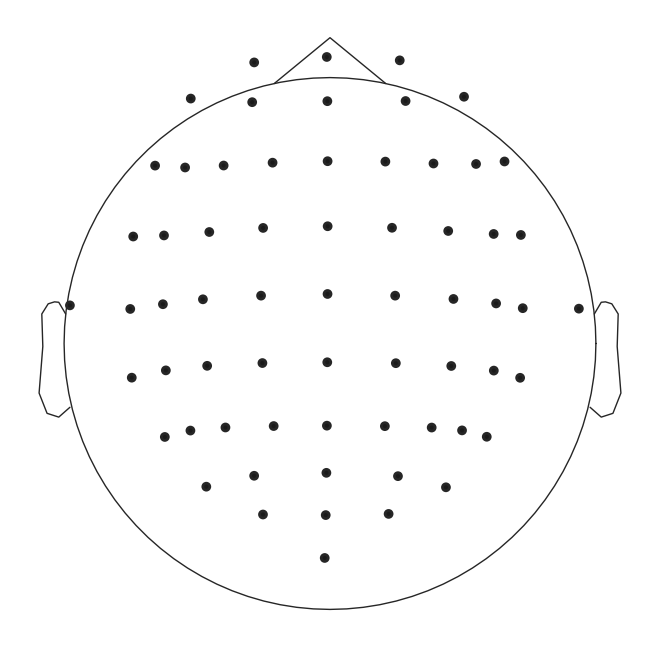

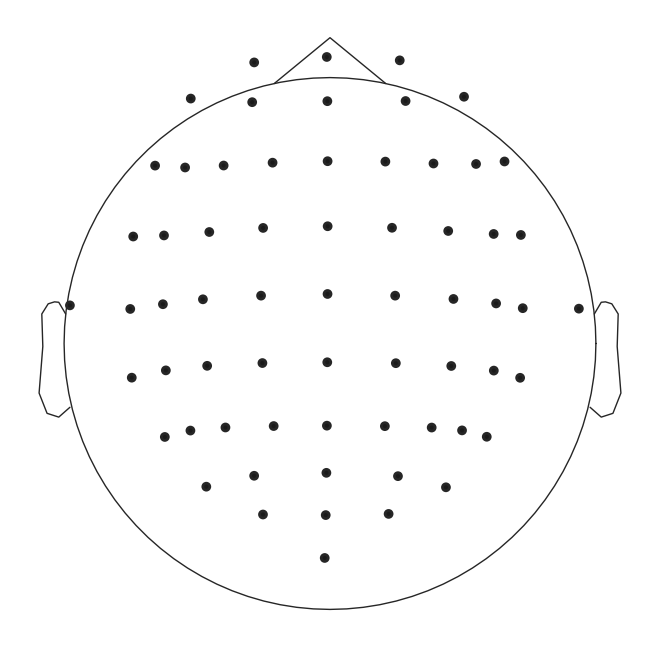

In [3]:
raw.plot_sensors()

Let's examine a brief segment of the EEG signal for the FP1 channel. The sample has been trimmed to a duration of only 6 seconds to facilitate a clearer visualization.

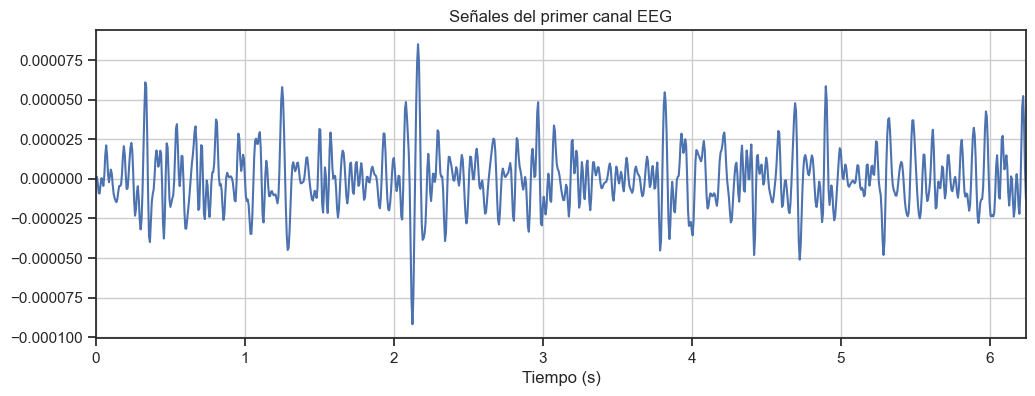

In [4]:
idx_channel = 0
n_samples = 1000
fs = 160
X = raw._data[idx_channel][:n_samples]
t = np.arange(X.shape[0]) / fs

plt.figure(figsize=(12, 4))
plt.plot(t, X)
plt.xlabel('Tiempo (s)')
plt.grid()
plt.title('Señales del primer canal EEG')
plt.xlim([t[0], t[-1]])
plt.show()

The ensemble of signals is then visualized using **Power Signal Density** (PSD) to obtain a representation of the filtering within the 7 Hz to 30 Hz range. It is within this frequency range that the motor impulses of the human body are predominantly present.

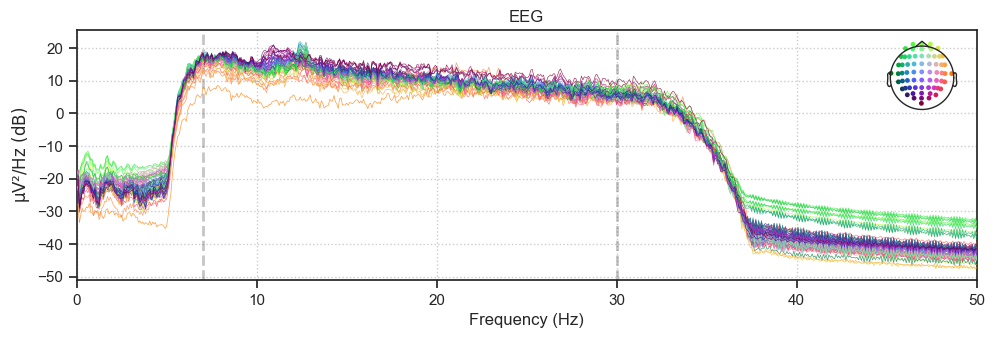

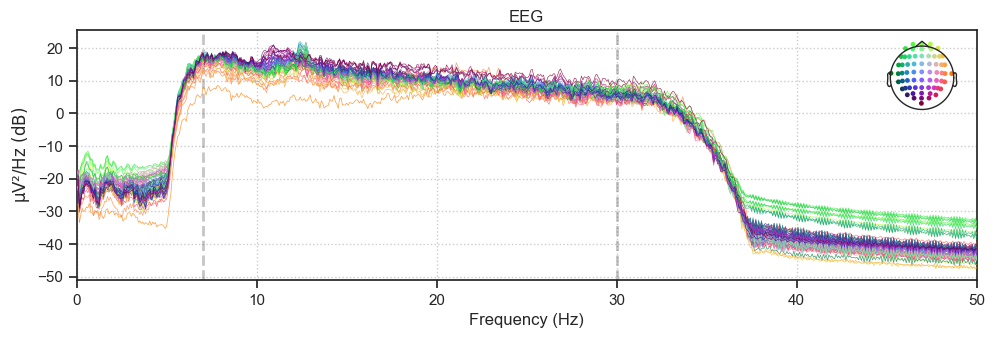

In [5]:
raw.compute_psd(fmax=50).plot(picks="data", exclude="bads")
# Se ve el filtrado de 7hz a 30hz

The impact of applying the bandpass filter to the signal can be observed in the following spectrogram.

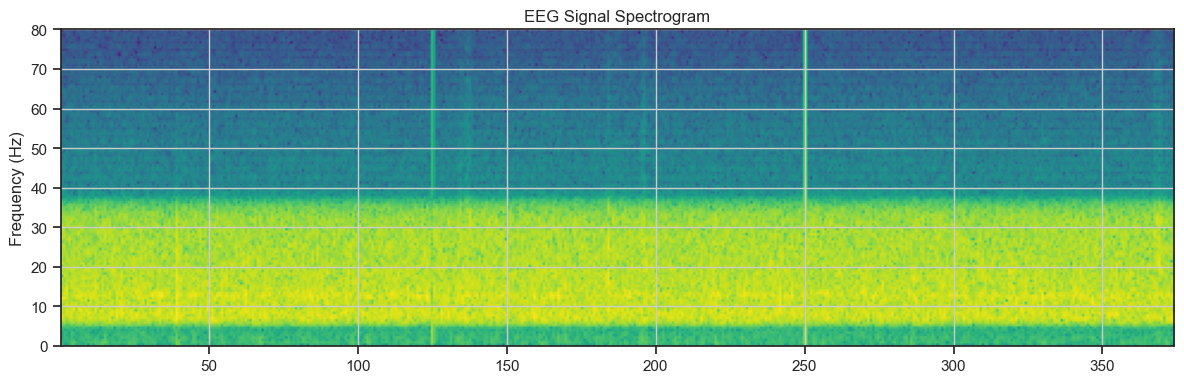

In [6]:
data_original = raw.copy().get_data()[0]

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(12, 4))

# Plot the spectrogram of the original unfiltered signal
ax1.specgram(data_original, Fs=raw.info['sfreq'], cmap='viridis')
ax1.set_title('EEG Signal Spectrogram')
ax1.set_ylabel('Frequency (Hz)')
ax1.grid()

# Adjust the figure layout and display the visualization
plt.tight_layout()
plt.show()

A **Common Spatial Patterns** (CSP) is applied to extract the four main components of the data. This allows us to visualize the four components and the areas of higher activity in the assigned task for Subject No. 1.

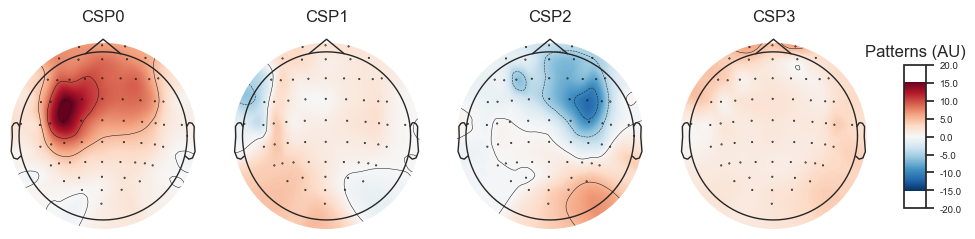

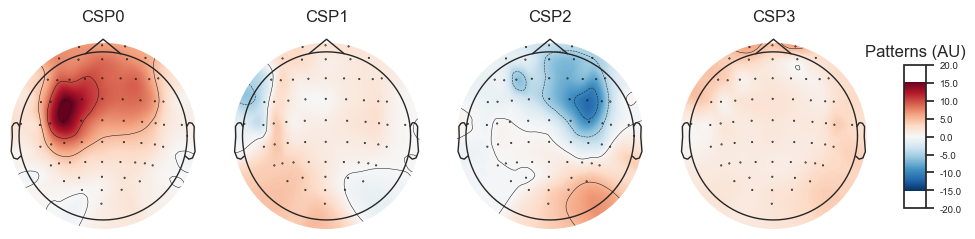

In [7]:
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()

csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)
csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)

The obtained components from the CSP can be visualized with greater precision.

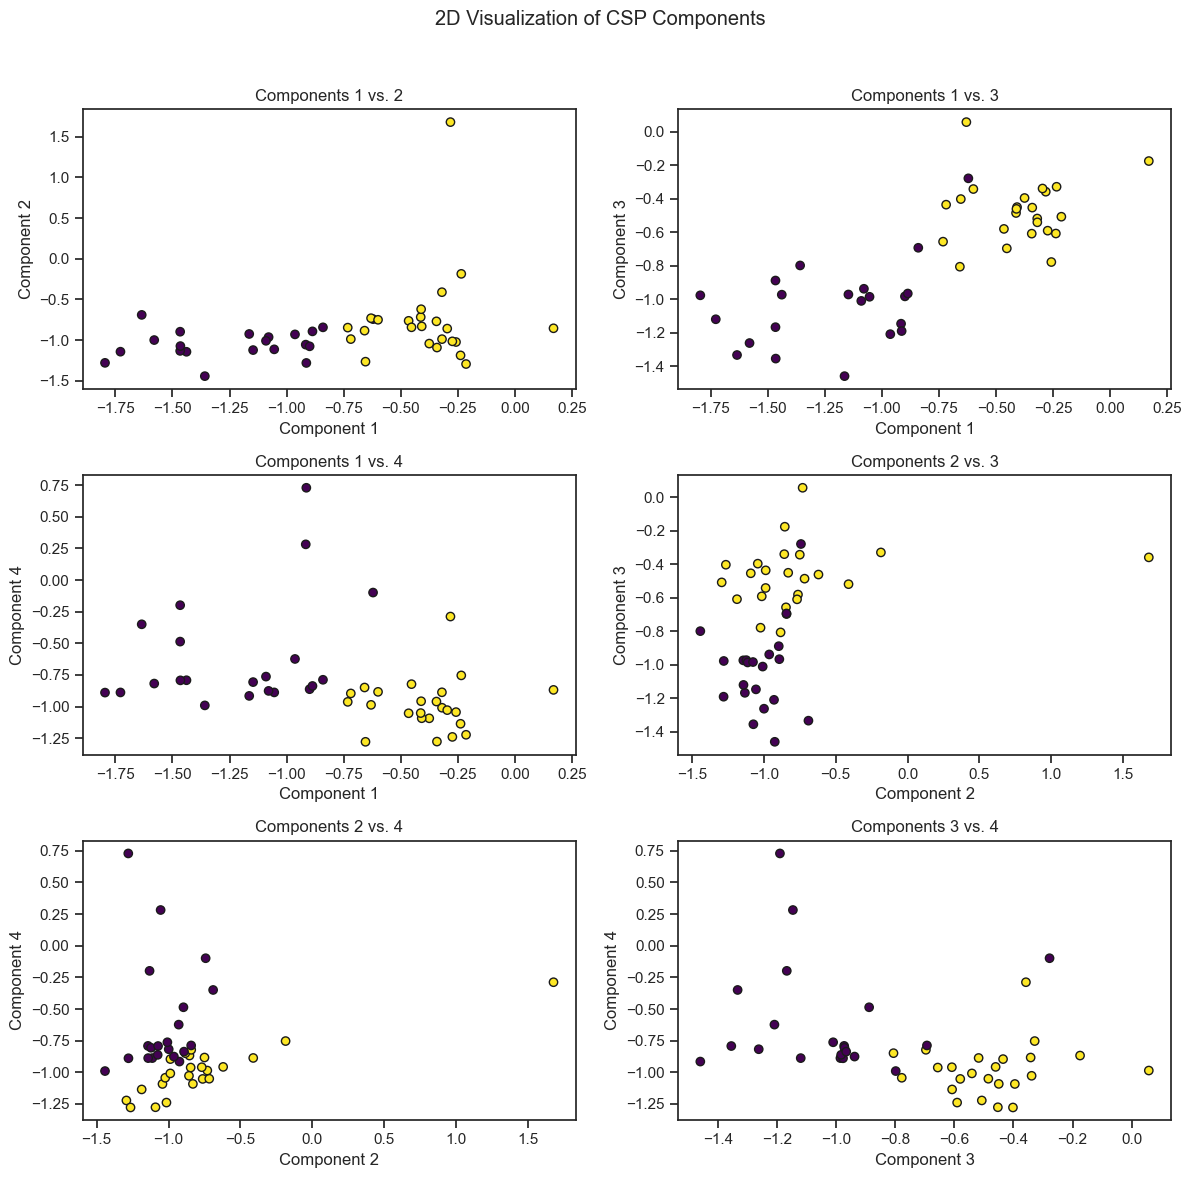

In [8]:
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Plot CSP patterns estimated on full data for visualization
X_train_reshaped_csp = csp.fit_transform(epochs_data, labels)

# Get all possible combinations of two components
combinations_2d = list(combinations(range(X_train_reshaped_csp.shape[1]), 2))

# Create subplots
fig, axes = plt.subplots(nrows=len(combinations_2d)//2, ncols=2, figsize=(12, 12))
fig.suptitle('2D Visualization of CSP Components')

# Visualize each combination in a 2D plot
for i, (component1, component2) in enumerate(combinations_2d):
    ax = axes[i // 2, i % 2]
    ax.scatter(X_train_reshaped_csp[:, component1], X_train_reshaped_csp[:, component2], c=labels, cmap='viridis', marker='o', edgecolors='k')
    ax.set_xlabel(f'Component {component1 + 1}')
    ax.set_ylabel(f'Component {component2 + 1}')
    ax.set_title(f'Components {component1 + 1} vs. {component2 + 1}')

# Adjust the layout and show the plots
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### Modeling Phase

For the modeling phase, we will experiment with various methods to perform a general classification of all signals from all subjects. In total, we have 109 subjects with approximately 45 samples each.

In [4]:
# Load data for all subjects
# Non-standardized data
X_train_reshaped, y_train, X_test_reshaped, y_test = split_eeg_data(standardize=False)
# Standardized data
X_train_reshaped_std, _, X_test_reshaped_std, _ = split_eeg_data(standardize=True)


  0%|          | 0/109 [00:00<?, ?it/s]

100%|██████████| 109/109 [01:34<00:00,  1.15it/s]


In [17]:
# Print shapes for verification
print("Shape of X_train_reshaped:", X_train_reshaped.shape)
print("Shape of X_test_reshaped:", X_test_reshaped.shape)
print("Shape of X_train_reshaped_std:", X_train_reshaped_std.shape)
print("Shape of X_test_reshaped_std:", X_test_reshaped_std.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train_reshaped: (4272, 64, 161)
Shape of X_test_reshaped: (475, 64, 161)
Shape of X_train_reshaped_std: (4272, 64, 161)
Shape of X_test_reshaped_std: (475, 64, 161)
Shape of y_train: (4272,)
Shape of y_test: (475,)


#### **Machine Learning:** Common Spatial Pattern - Linear Discriminant Analysis (CSP-LDA)

We first experiment with the classical techniques commonly used in the literature.

In [12]:
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
lda = LinearDiscriminantAnalysis()

In [13]:
X_train_reshaped_csp = csp.fit_transform(X_train_reshaped, y_train)
X_test_reshaped_csp  = csp.transform(X_test_reshaped)

In [14]:
# Entrenamos el modelo
lda.fit(X_train_reshaped_csp, y_train)

# Predicciones en el conjunto de prueba
y_pred = lda.predict(X_test_reshaped_csp)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Otras métricas y matriz de confusión
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.6463157894736842
              precision    recall  f1-score   support

           0       0.62      0.69      0.65       230
           1       0.67      0.61      0.64       245

    accuracy                           0.65       475
   macro avg       0.65      0.65      0.65       475
weighted avg       0.65      0.65      0.65       475

[[158  72]
 [ 96 149]]


#### **Deep Learning:** Convolutional Neural Networks (CNNs) y Neural Networks (NNs)

##### Experiment No. 1: CNN

In [18]:
# Build the CNN model
model = Sequential()
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64, 161, 1)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile model
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 62, 159, 32)       320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 31, 79, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 77, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 38, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 34048)             0         
                                                                 
 dense_2 (Dense)             (None, 64)               

Without standardization:

In [19]:
# Train the model and store the history
history = model.fit(X_train_reshaped, y_train, epochs=30, validation_data=(X_test_reshaped, y_test))
evaluate_and_visualize(model, history, X_test_reshaped, y_test)

Epoch 1/30


134/134 [==============================] - 23s 148ms/step - loss: 0.6932 - accuracy: 0.4841 - val_loss: 0.6931 - val_accuracy: 0.5158
Epoch 2/30
134/134 [==============================] - 20s 147ms/step - loss: 0.6932 - accuracy: 0.5007 - val_loss: 0.6932 - val_accuracy: 0.4842
Epoch 3/30
134/134 [==============================] - 22s 163ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6932 - val_accuracy: 0.4842
Epoch 4/30
134/134 [==============================] - 22s 162ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6932 - val_accuracy: 0.4842
Epoch 5/30
134/134 [==============================] - 21s 160ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6932 - val_accuracy: 0.4842
Epoch 6/30
134/134 [==============================] - 23s 173ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6932 - val_accuracy: 0.4842
Epoch 7/30
134/134 [==============================] - 26s 191ms/step - loss: 0.6932 - accuracy: 0.4918 - val_loss: 0.6932 - val_

0.4842105263157895

With standardization:

In [20]:
# Train the model and store the history
history = model.fit(X_train_reshaped_std, y_train, epochs=30, validation_data=(X_test_reshaped_std, y_test))
evaluate_and_visualize(model, history, X_test_reshaped_std, y_test)

Epoch 1/30
134/134 [==============================] - 23s 172ms/step - loss: 0.7286 - accuracy: 0.4911 - val_loss: 0.6932 - val_accuracy: 0.4842
Epoch 2/30
134/134 [==============================] - 22s 166ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6933 - val_accuracy: 0.4842
Epoch 3/30
134/134 [==============================] - 23s 169ms/step - loss: 0.6932 - accuracy: 0.4974 - val_loss: 0.6933 - val_accuracy: 0.4842
Epoch 4/30
134/134 [==============================] - 23s 171ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6933 - val_accuracy: 0.4842
Epoch 5/30
134/134 [==============================] - 25s 183ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6933 - val_accuracy: 0.4842
Epoch 6/30
134/134 [==============================] - 23s 175ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6933 - val_accuracy: 0.4842
Epoch 7/30
134/134 [==============================] - 24s 178ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6934 - val_ac

0.4842105263157895

##### Experiment No. 2: NN-CSP

In [21]:
n_csp_components = 4

# Build the NN model
model = Sequential()
model.add(layers.Dense(30, activation='relu', input_shape=(n_csp_components,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile model
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 30)                150       
                                                                 
 dense_5 (Dense)             (None, 30)                930       
                                                                 
 dense_6 (Dense)             (None, 1)                 31        
                                                                 
Total params: 1111 (4.34 KB)
Trainable params: 1111 (4.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Without standardization:

In [22]:
csp = CSP(n_components=n_csp_components, reg=None, log=True, norm_trace=False)
X_train_reshaped_csp = csp.fit_transform(X_train_reshaped, y_train)
X_test_reshaped_csp  = csp.transform(X_test_reshaped)
history = model.fit(X_train_reshaped_csp, y_train, epochs=30, validation_data=(X_test_reshaped_csp, y_test))
evaluate_and_visualize(model, history, X_test_reshaped_csp, y_test)

Epoch 1/30
134/134 [==============================] - 2s 5ms/step - loss: 0.6748 - accuracy: 0.5969 - val_loss: 0.6482 - val_accuracy: 0.6400
Epoch 2/30
134/134 [==============================] - 0s 3ms/step - loss: 0.6486 - accuracy: 0.6107 - val_loss: 0.6434 - val_accuracy: 0.6358
Epoch 3/30
134/134 [==============================] - 0s 3ms/step - loss: 0.6441 - accuracy: 0.6180 - val_loss: 0.6433 - val_accuracy: 0.6400
Epoch 4/30
134/134 [==============================] - 0s 3ms/step - loss: 0.6415 - accuracy: 0.6199 - val_loss: 0.6429 - val_accuracy: 0.6274
Epoch 5/30
134/134 [==============================] - 0s 2ms/step - loss: 0.6405 - accuracy: 0.6245 - val_loss: 0.6392 - val_accuracy: 0.6421
Epoch 6/30
134/134 [==============================] - 0s 3ms/step - loss: 0.6398 - accuracy: 0.6292 - val_loss: 0.6385 - val_accuracy: 0.6442
Epoch 7/30
134/134 [==============================] - 0s 3ms/step - loss: 0.6381 - accuracy: 0.6252 - val_loss: 0.6384 - val_accuracy: 0.6295
Epoch 

0.64

With standardization:

In [23]:
csp = CSP(n_components=n_csp_components, reg=None, log=True, norm_trace=False)
X_train_reshaped_csp_std = csp.fit_transform(X_train_reshaped_std, y_train)
X_test_reshaped_csp_std  = csp.transform(X_test_reshaped_std)
history = model.fit(X_train_reshaped_csp_std, y_train, epochs=30, validation_data=(X_test_reshaped_csp_std, y_test))
evaluate_and_visualize(model, history, X_test_reshaped_csp_std, y_test)

Epoch 1/30
134/134 [==============================] - 0s 3ms/step - loss: 0.6313 - accuracy: 0.6327 - val_loss: 0.6389 - val_accuracy: 0.6189
Epoch 2/30
134/134 [==============================] - 0s 3ms/step - loss: 0.6316 - accuracy: 0.6334 - val_loss: 0.6379 - val_accuracy: 0.6337
Epoch 3/30
134/134 [==============================] - 0s 3ms/step - loss: 0.6308 - accuracy: 0.6325 - val_loss: 0.6352 - val_accuracy: 0.6295
Epoch 4/30
134/134 [==============================] - 0s 3ms/step - loss: 0.6303 - accuracy: 0.6344 - val_loss: 0.6372 - val_accuracy: 0.6253
Epoch 5/30
134/134 [==============================] - 0s 3ms/step - loss: 0.6301 - accuracy: 0.6339 - val_loss: 0.6375 - val_accuracy: 0.6358
Epoch 6/30
134/134 [==============================] - 0s 3ms/step - loss: 0.6313 - accuracy: 0.6313 - val_loss: 0.6343 - val_accuracy: 0.6379
Epoch 7/30
134/134 [==============================] - 0s 3ms/step - loss: 0.6296 - accuracy: 0.6369 - val_loss: 0.6350 - val_accuracy: 0.6400
Epoch 

0.6294736842105263

### Results Analysis

As we can observe, the models used in the modeling phase do not achieve decent results. Overall, all employed models have an accuracy around $60\%$, only $10\%$ above the $50\%$ that would be obtained by random guessing. In the following visualization, we present the result of applying CSP to all subjects simultaneously.       

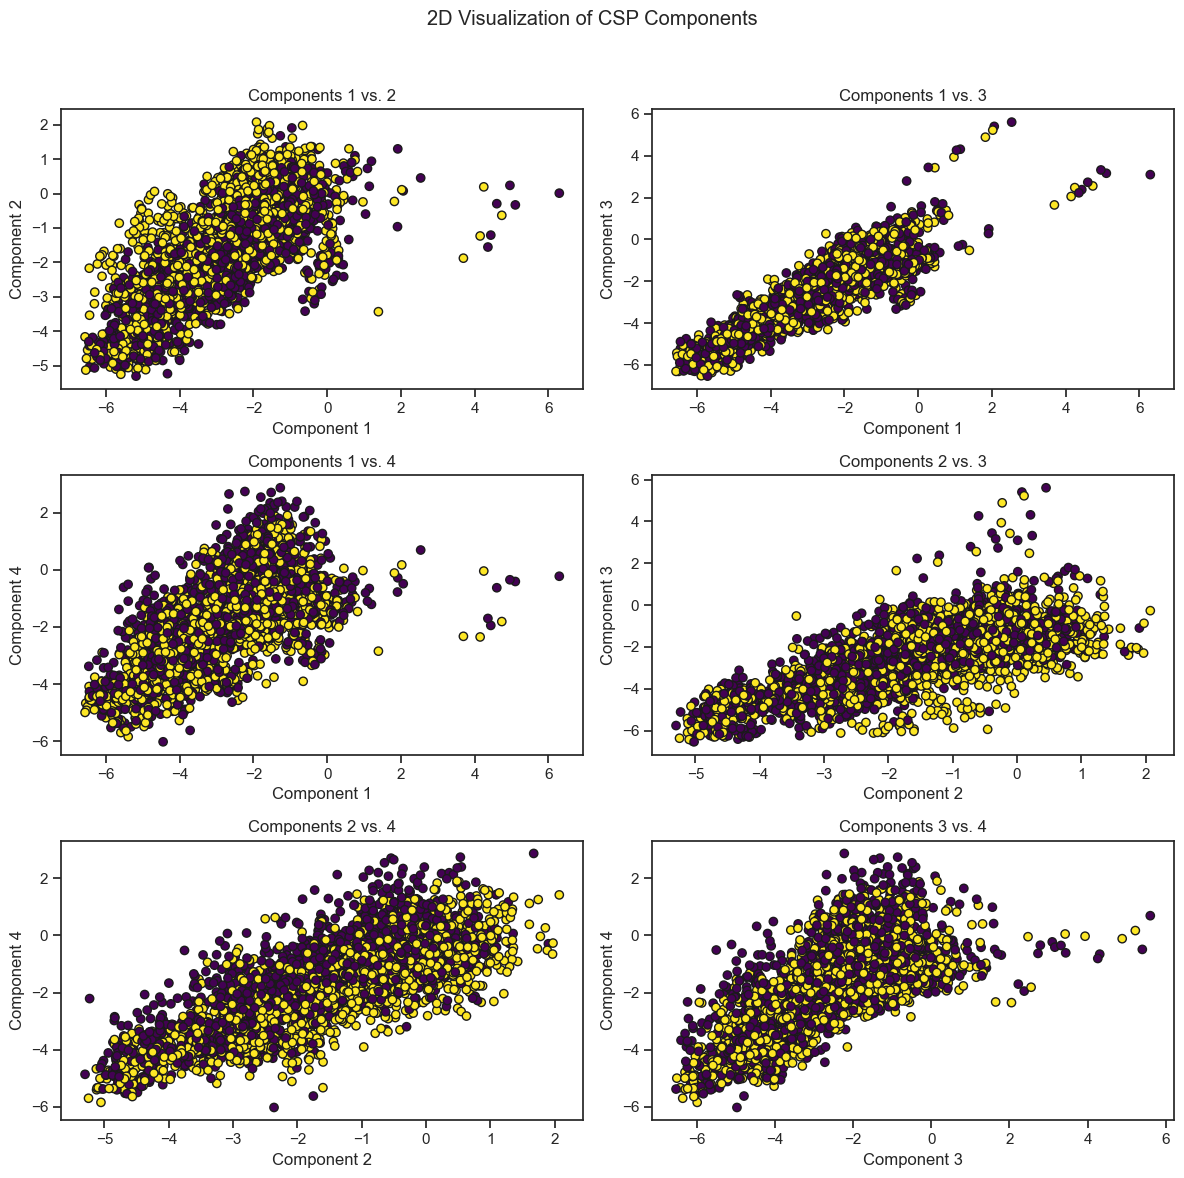

In [26]:
visualize_csp_components(X_train_reshaped, y_train, num_csp_components=4)

As observed in the previous figure, the data is practically inseparable. This makes it challenging, if not impossible, for the methods used for signal classification. However, when we employ the techniques previously used individually for each subject, we obtain good results for certain specific patients. This type of technique is referred to as [Subject-dependent EEG classification](https://dl.acm.org/doi/10.1145/3388142.3388167).

100%|██████████| 109/109 [01:24<00:00,  1.29it/s]


# Subjects processed: 106 / 110  (96.36%)
Mean: 0.6377358490566037
Variance: 0.06876468494126024
Minimum: 0.0
Maximum: 1.0
Median: 0.6
Mode: 0.8


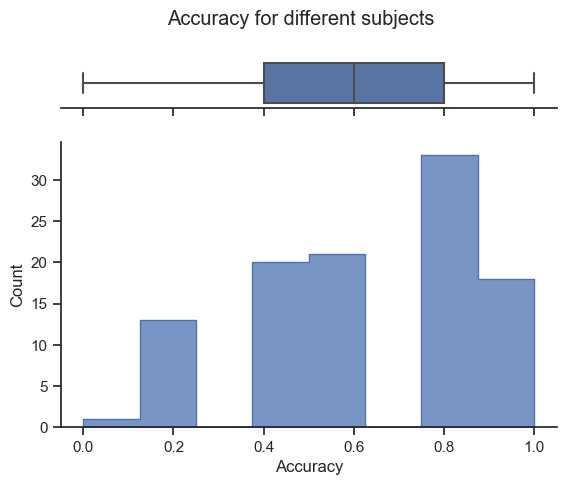

In [2]:
# Prediction with CSP-LDA
acc_results_csplda = classify_individual_subjects(use_lda=True)
idx_csplda = index_below_threshold(acc_results_csplda, threshold=0.6)
display_descriptive_statistics(acc_results_csplda)

  4%|▎         | 4/109 [00:23<10:24,  5.95s/it]

  5%|▍         | 5/109 [00:29<10:14,  5.91s/it]

100%|██████████| 109/109 [11:03<00:00,  6.08s/it]


# Subjects processed: 106 / 110  (96.36%)
Mean: 0.6433962264150942
Variance: 0.0724563901744393
Minimum: 0.0
Maximum: 1.0
Median: 0.6
Mode: 0.8


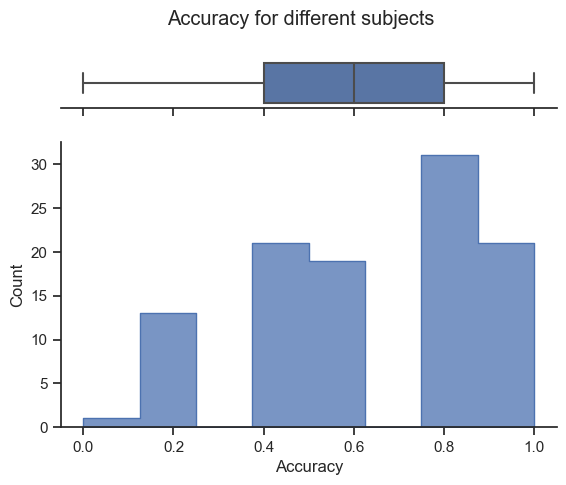

In [3]:
# Prediction with CSP-NN
acc_results_nn = classify_individual_subjects(use_lda=False)
idx_nn = index_below_threshold(acc_results_nn, threshold=0.6)
display_descriptive_statistics(acc_results_nn)

We can see that there is not much difference between applying LDA and a neural network to the data obtained by CSP. It is worth noting that predicting classes randomly should result in around $50\%$ accuracy. However, there are several subjects where the models perform below this threshold. Let's take a look at a graph where we show the best results obtained by LDA and the neural network.

Mean: 0.6867924528301885
Variance: 0.0626557493770025
Minimum: 0.2
Maximum: 1.0
Median: 0.8
Mode: 0.8


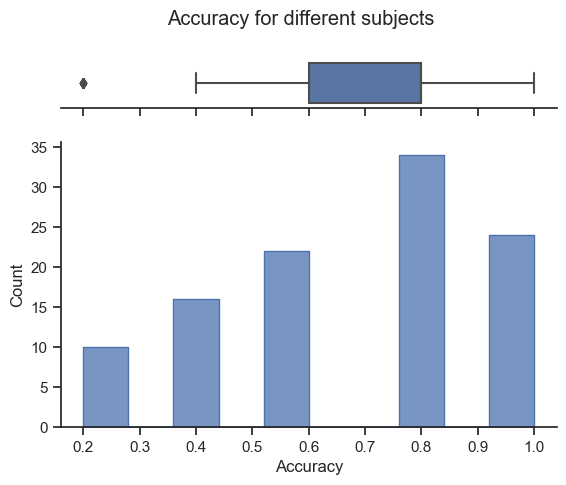

In [4]:
max_value = [max(csplda, nn) for csplda, nn in zip(acc_results_csplda, acc_results_nn)]
display_descriptive_statistics(max_value)

Next, let's take a look at the CSP obtained from a subject where good results have not been achieved using either LDA or a neural network.

Subject ID: 14   Best accuracy from both models:  0.2


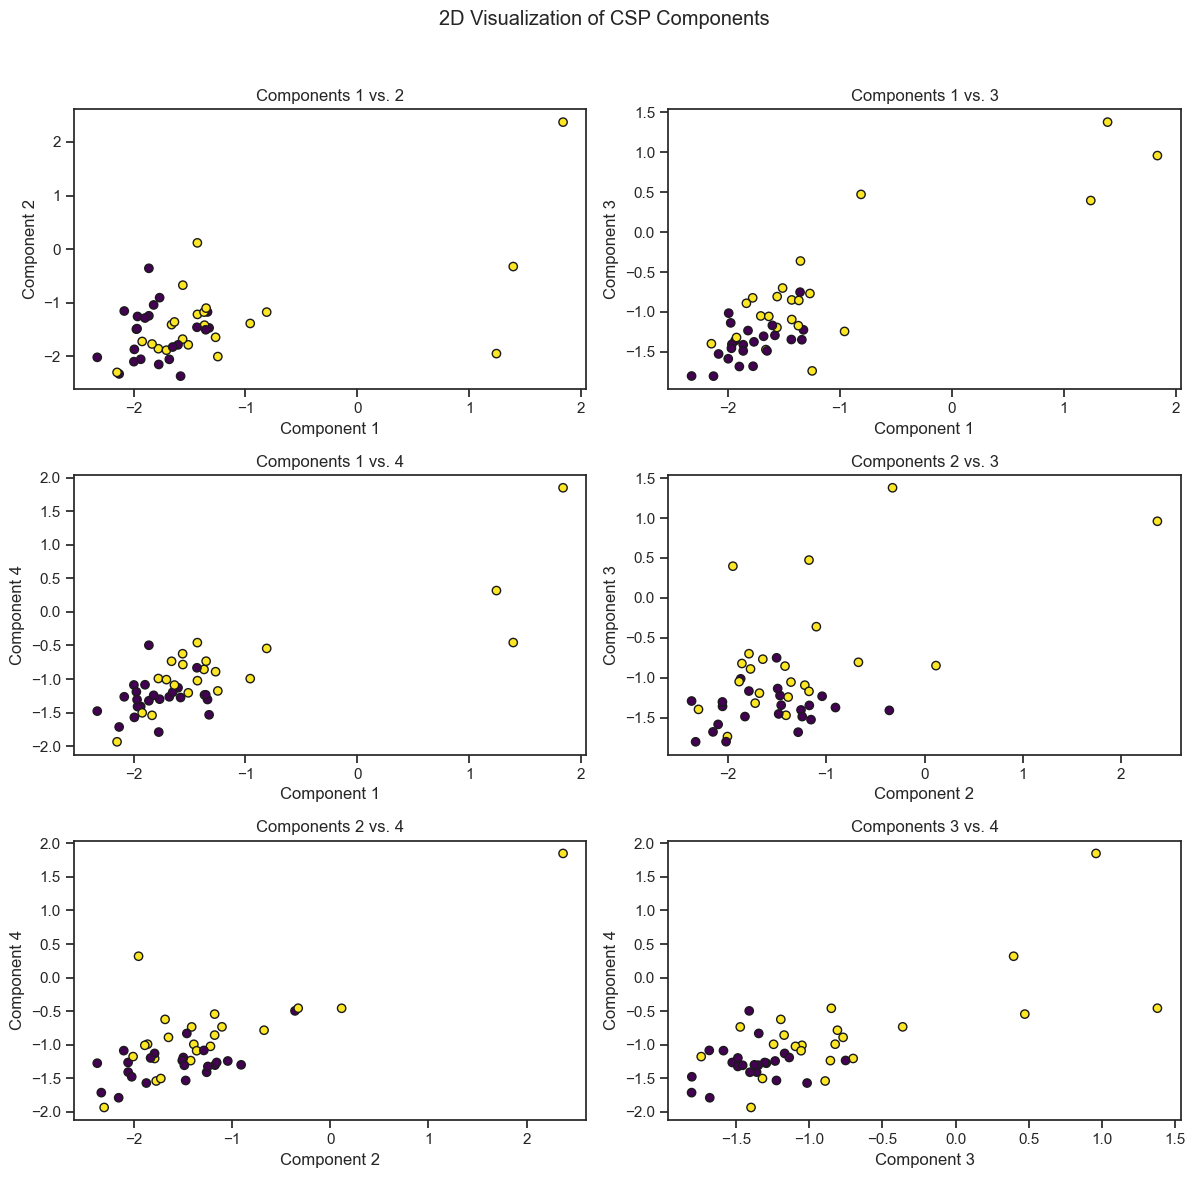

In [15]:
# vals = index_below_threshold(max_value, threshold=0.2)
vals = [(k + 1, v) for k, v in enumerate(max_value) if v <= 0.2]
id_bad_subject = vals[3][0]
epochs_train, all_labels = extract_motor_imagery_data(id_bad_subject)
all_data = epochs_train.get_data()
print(f'Subject ID: {vals[1][0]}   Best accuracy from both models:  {vals[1][1]}')
visualize_csp_components(all_data, all_labels, num_csp_components=4)


As we can see, the samples obtained from these types of patients are quite challenging to distinguish as they are mixed together. Therefore, our next course of action is to explore the feasibility of using a pre-trained spectral transformer with the entire dataset of subjects and perform fine-tuning on patients where the distance between classes is quite small. The aim is to achieve better predictions than the models previously used.

### Spectral Transformer

For the spectral transformer, we have used the architecture designed in [this paper](https://www.sciencedirect.com/science/article/abs/pii/S1746809423005633) published on June 8, 2023. To have a reference metric for the quality of our spectral transformer, we will compare it with a state-of-the-art transformer in the classification of motor EEG signals. This model is an Attention Temporal Convolutional Network (ATCNet) published in [this paper](https://ieeexplore.ieee.org/document/9852687) on August 9, 2022. The ATCNet model is evaluated using the [BCI Competition IV-2a dataset](https://lampx.tugraz.at/~bci/database/001-2014/description.pdf), which is frequently used to compare neuromotor signal classification models. The dataset is developed by Graz University of Technology in Austria and contains files from 9 different subjects. For each subject, there are 288 training samples and 288 testing samples. The only difference between this dataset and the one initially used is that it classifies 4 classes instead of the original 2.

#### Implementation

The spectral transformer uses the PSD signals as input to the model. Once the signal is transformed, a Positional Encoding is added to it. Then, it passes through a dense layer and is inserted into the encoding block. Finally, it undergoes Global Average Pooling and passes through a classification layer. The structure of the Transformer is detailed in the following image.

<figure>
    <img src="img/st.png" alt="Texto alternativo" style="width:200px; display:block; margin:auto; border:2px dashed #6495ED;" />
    <figcaption style="text-align:center; color:#6495ED; font-style:italic; font-size:18px;">Spectral Transformer</figcaption>
</figure>


For the encoding block, a Pre-LN Transformer is employed. This variation of the transformer arises as a solution to the traditional Post-LN Transformer structure. The latter type of transformer exhibits gradient instability in the Multi-Head Attention layer, necessitating the use of Gradient Warmup during training. As a solution, Pre-LN Transformers change the location of the normalization layer and place it before the Multi-Head Attention layer. The following figure details this explanation:

<figure>
    <img src="img/preln.png" alt="Texto alternativo" style="width:200px; display:block; margin:auto; border:2px dashed #6495ED;" />
    <figcaption style="text-align:center; color:#6495ED; font-style:italic; font-size:18px;">Pre-LN Transformer</figcaption>
</figure>

Let's define the functions that we will use for our **spectral transformer** layer by layer. The **ATCNet** model will be implemented in the *models.py* file. We don't display it in this notebook as it was not part of our main research focus, but rather as a means of comparing our model.

In [2]:
def calculate_psd(data, fs=250):
    """
    Calculates Power Spectral Density (PSD) for each channel in each sample of an EEG dataset.

    Parameters:
    - data (numpy.ndarray): EEG data in the format (n_samples, n_channels, n_samples_per_channel).
    - fs (int): Sampling frequency in Hz.

    Returns:
    - result_data (numpy.ndarray): 3D array containing the calculated PSDs.
    """
    # Calculate the length of the Fourier window
    size_signal = data.shape[2]
    nfft = 2**int(np.ceil(np.log2(size_signal)))

    # Initialize a list to store the PSD results
    result_data = []

    # Iterate over each sample in the dataset
    for i in tqdm(range(data.shape[0])):  
        # Initialize a list to store the PSDs of each channel in the sample
        list_psd = []

        # Iterate over each channel in the sample
        for j in range(data.shape[1]):  
            # Get data from the current channel
            channel_data = data[i, j, :]

            # Calculate the PSD using the welch function from SciPy
            _, psd = welch(channel_data, fs=fs, nperseg=nfft, noverlap=0, nfft=nfft, scaling='density')

            # Add the calculated PSD to the list
            list_psd.append(psd)

        # Add the list of PSDs from the current sample to the results
        result_data.append(list_psd)

    # Convert the results to a numpy array and return them
    return np.array(result_data)

In [3]:
class PreLNEncoder(layers.Layer):
    """
    Implementation of an encoder layer with attention and dense projections for the Spectral Transformer model.

    Parameters:
    - dense_dim (tuple): Dimensions for the dense layers.
    - num_heads (int): Number of heads for multi-head attention.
    - head_size (int): Size of the head for multi-head attention.
    - kernel_regularizer: Kernel regularization for dense layers.
    - kwargs: Additional arguments for the layer.

    """
    def __init__(self, dense_dim, num_heads, head_size, kernel_regularizer, **kwargs):
        super().__init__(**kwargs)
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.head_size = head_size
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=head_size)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim[0], activation="relu", kernel_regularizer=kernel_regularizer),
             layers.Dense(dense_dim[1], activation="relu", kernel_regularizer=kernel_regularizer),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.add1 = layers.Add()
        self.add2 = layers.Add()

    def call(self, inputs): 
        """
        Call method for the PreLNEncoder layer.

        Parameters:
        - inputs: Input data.

        Returns:
        - output: Layer output.

        """
        # Normalization and attention
        firstNorm_out = self.layernorm_1(inputs)
        attention_output = self.attention(firstNorm_out, firstNorm_out, attention_mask=None)
        
        # Residual connection and more normalization
        add1_out = self.add1([inputs, attention_output])
        secondNorm_out = self.layernorm_2(add1_out)
        
        # Dense projection and another residual connection
        dense_output = self.dense_proj(secondNorm_out)
        output = self.add2([add1_out, dense_output])
        
        return output

    def get_config(self):
        """
        Get the configuration of the PreLNEncoder layer.

        Returns:
        - config: Layer configuration.

        """
        config = super().get_config()
        config.update({
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
            "head_size": self.head_size,
            "kernel_regularizer": self.kernel_regularizer
        })
        return config

In [4]:
class PositionalEmbedding(layers.Layer):
    """
    Implementation of a positional embedding layer for the Spectral Transformer model.

    Parameters:
    - kwargs: Additional arguments for the layer.

    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        """
        Build the weights of the layer.

        Parameters:
        - input_shape: Shape of the input data. 
        (batch_size, n_samples_per_channel, n_channels)

        """
        _, sequence_length, embed_dim = input_shape
        self.position_embeddings = self.add_weight(
            shape=(sequence_length, embed_dim),
            initializer="uniform",
            trainable=True,
        )
        super().build(input_shape)

    def call(self, inputs):
        """
        Call method for the PositionalEmbedding layer.

        Parameters:
        - inputs: Input data.

        Returns:
        - output: Layer output.

        """
        positions = tf.range(start=0, limit=tf.shape(inputs)[-2], delta=1)
        embedded_positions = tf.expand_dims(self.position_embeddings, 0)
        return inputs + embedded_positions

    def get_config(self):
        """
        Get the configuration of the PositionalEmbedding layer.

        Returns:
        - config: Layer configuration.

        """
        config = super().get_config()
        return config


In [5]:
class SpectralTransformer(layers.Layer):
    def __init__(self, dense_dim, n_classes, encoder_dense_dims, kernel_regularizer, dropout=0.5, num_heads=8, head_size=128, num_stacked_transformers=4, **kwargs):
        """
        Implementation of a Spectral Transformer model with multiple stacked transformer layers.

        Parameters:
        - dense_dim (tuple): Dimensions for the dense layers.
        - n_channels (int): Number of channels.
        - encoder_dense_dims (tuple): Dimensions for the dense layers of the encoder.
        - kernel_regularizer: Kernel regularization for dense layers.
        - dropout (float): Dropout rate.
        - num_heads (int): Number of heads for multi-head attention.
        - head_size (int): Size of the head for multi-head attention.
        - num_stacked_transformers (int): Number of stacked transformers.
        - kwargs: Additional arguments for the layer.

        """
        super().__init__(**kwargs)
        self.num_stacked_transformers = num_stacked_transformers
        self.positional_embedding = PositionalEmbedding()
        self.dense1 = layers.Dense(dense_dim[0], activation='relu', kernel_regularizer=kernel_regularizer)
        self.dense2 = layers.Dense(dense_dim[1], activation='relu', kernel_regularizer=kernel_regularizer)
        self.dense3 = layers.Dense(n_classes, activation='softmax')
        self.dropout_layers = [layers.Dropout(dropout) for _ in range(num_stacked_transformers)]
        self.preLN_encoders = [PreLNEncoder(dense_dim=encoder_dense_dims, num_heads=num_heads, head_size=head_size, kernel_regularizer=kernel_regularizer) for _ in range(num_stacked_transformers)]
        self.GlobalMaxPooling1D = layers.GlobalMaxPooling1D()

    def call(self, inputs):
        """
        Call method for the SpectralTransformer layer.

        Parameters:
        - inputs: Input data.

        Returns:
        - x: Model output.

        """
        x = self.positional_embedding(inputs)
        x = self.dense1(x)

        # Stacked Transformers
        for i in range(self.num_stacked_transformers):
            x = self.dropout_layers[i](x)
            x = self.preLN_encoders[i](x)

        x = self.GlobalMaxPooling1D(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return x

    def get_config(self):
        """
        Get the configuration of the SpectralTransformer layer.

        Returns:
        - config: Layer configuration.

        """
        config = super().get_config()
        config.update({
            "dense_dim": self.dense_dim,
            "n_channels": self.n_channels,
            "num_heads": self.num_heads,
            "encoder_dense_dims": self.encoder_dense_dims,
            "kernel_regularizer": self.kernel_regularizer,
            "dropout": self.dropout,
            "head_size": self.head_size,
            "num_stacked_transformers": self.num_stacked_transformers
        })
        return config


We will conduct a test of our model using the BCI competition data. According to the original paper, the number of stacked transformers should be set to 4. However, after a series of experiments, we have found that setting it to 1 yields better results. We omit the experimentation code to make this notebook visually more concise and for code simplicity. In case you want to try different values, feel free to modify the line below.


In [6]:
# Modify if you want to experiment with other values
num_stacked_transformers = 1

Now, let's test the model with the data from subject number 2 in the dataset.


In [7]:
# Define the subject ID and the data path
subject_number = 2
data_path = './BCI Competition IV-2a/'

In [8]:
# Get the training and testing data
X_train, y_train, y_train_onehot, X_test, y_test, y_test_onehot = get_BCI_competition_data(data_path, subject_number, isStandard=True)

In [9]:
# Calculate the Power Spectral Density (PSD) for the training and testing data
X_train_psd = np.transpose(calculate_psd(X_train), (0, 2, 1))
X_test_psd = np.transpose(calculate_psd(X_test), (0, 2, 1))

100%|██████████| 288/288 [00:02<00:00, 115.83it/s]


In [26]:
# Get the dimensions of the PSD data
n_samples = X_train_psd.shape[1]
n_channels = X_train_psd.shape[2]

In [27]:
# Set up the optimizer
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=100,
    decay_rate=0.99,
    staircase=True
)

In [28]:
# Define Early Stopping
early_stopping = EarlyStopping(monitor='val_loss',  # You can change to 'val_accuracy' or other metrics
                               patience=1000,  # Number of epochs with no improvement before stopping
                               restore_best_weights=True,  # Restore model weights to the best epoch
                               verbose=1)  # Show detailed messages


In [29]:
# Define the Spectral Transformer model
inputs = keras.Input(shape=(n_samples, n_channels))

# Build the model using the SpectralTransformer class
output = SpectralTransformer(dense_dim=(64, 128),
                             n_classes=4,
                             encoder_dense_dims=(32, 64),
                             kernel_regularizer=regularizers.l1(0.0005),
                             dropout=0.5,
                             num_heads=8,
                             head_size=128,
                             num_stacked_transformers=num_stacked_transformers)(inputs)

# Create the model
SpectralTrans = keras.Model(inputs, output)

# Compile the model
SpectralTrans.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule),
                      loss="categorical_crossentropy",
                      metrics=["accuracy"])

# Show a summary of the model
SpectralTrans.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1025, 22)]        0         
                                                                 
 spectral_transformer_1 (Sp  (None, 4)                 302586    
 ectralTransformer)                                              
                                                                 
Total params: 302586 (1.15 MB)
Trainable params: 302586 (1.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
# Train the model
SpectralTrans.fit(X_train_psd,  # Training data
                  y_train_onehot,  # Training labels
                  epochs=500,  # Number of training epochs
                  batch_size=32,  # Batch size
                  validation_data=(X_test_psd, y_test_onehot),
                  callbacks=[early_stopping])  # Validation data


Epoch 1/500
9/9 [==============================] - 2s 142ms/step - loss: 2.2260 - accuracy: 0.2257 - val_loss: 2.1583 - val_accuracy: 0.1840
Epoch 2/500
9/9 [==============================] - 1s 120ms/step - loss: 2.1171 - accuracy: 0.2535 - val_loss: 2.1557 - val_accuracy: 0.2465
Epoch 3/500
9/9 [==============================] - 1s 122ms/step - loss: 2.1061 - accuracy: 0.2465 - val_loss: 2.1272 - val_accuracy: 0.2257
Epoch 4/500
9/9 [==============================] - 1s 121ms/step - loss: 2.0820 - accuracy: 0.3333 - val_loss: 2.1148 - val_accuracy: 0.2153
Epoch 5/500
9/9 [==============================] - 1s 121ms/step - loss: 2.0911 - accuracy: 0.2743 - val_loss: 2.1031 - val_accuracy: 0.2847
Epoch 6/500
9/9 [==============================] - 1s 120ms/step - loss: 2.0692 - accuracy: 0.3194 - val_loss: 2.1046 - val_accuracy: 0.2604
Epoch 7/500
9/9 [==============================] - 1s 121ms/step - loss: 2.0679 - accuracy: 0.3438 - val_loss: 2.0937 - val_accuracy: 0.2639
Epoch 8/500
9

9/9 [==============================] - 0s 30ms/step
Accuracy: 0.6458333333333334
Precision: 0.6306814201281414
Recall: 0.6458333333333334
F1 Score: 0.6053035049745575


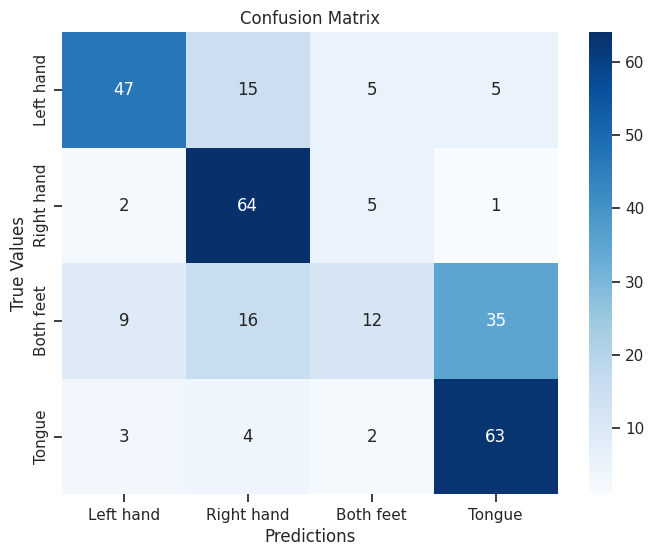

In [31]:
y_pred = SpectralTrans.predict(X_test_psd)
evaluate_classification_metrics(y_test_onehot, y_pred)

##### Benchmarks

Now, let's see the results obtained by the state-of-the-art ATCNet model. As mentioned earlier, this model is implemented in the *models.py* file.


In [32]:
# Definir el ID del sujeto y la ruta de los datos
subject_number = 2
data_path = './BCI Competition IV-2a/'

In [33]:
# Obtener los datos de entrenamiento y prueba
X_train, _, y_train_onehot, X_test, _, y_test_onehot = get_BCI_competition_data(data_path, subject_number, isStandard=True)
X_train = X_train[:, np.newaxis, :, :]
X_test = X_test[:, np.newaxis, :, :]

In [34]:
ATCNet_model = create_ATCNet()    

In [35]:
ATCNet_model.compile(loss=categorical_crossentropy, 
                     optimizer=Adam(learning_rate=0.0009), 
                     metrics=['accuracy'])  

In [36]:
ATCNet_model.fit(X_train, 
                y_train_onehot, 
                validation_data=(X_test, y_test_onehot), 
                epochs=500, 
                batch_size=64)

Epoch 1/500


2024-01-10 20:12:48.604261: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/conv_block/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-01-10 20:12:49.563211: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-10 20:12:50.260872: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f6b0c35ff30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-10 20:12:50.260904: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2024-01-10 20:12:50.266741: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-10 20:12:50.331523: I ./tensorflow/comp

5/5 [==============================] - 11s 251ms/step - loss: 1.6948 - accuracy: 0.2431 - val_loss: 1.3851 - val_accuracy: 0.2604
Epoch 2/500
5/5 [==============================] - 0s 58ms/step - loss: 1.3848 - accuracy: 0.3125 - val_loss: 1.3933 - val_accuracy: 0.2396
Epoch 3/500
5/5 [==============================] - 0s 54ms/step - loss: 1.3554 - accuracy: 0.3542 - val_loss: 1.4192 - val_accuracy: 0.2431
Epoch 4/500
5/5 [==============================] - 0s 63ms/step - loss: 1.3043 - accuracy: 0.4132 - val_loss: 1.4743 - val_accuracy: 0.2535
Epoch 5/500
5/5 [==============================] - 0s 58ms/step - loss: 1.2775 - accuracy: 0.4062 - val_loss: 1.5638 - val_accuracy: 0.2465
Epoch 6/500
5/5 [==============================] - 0s 55ms/step - loss: 1.2232 - accuracy: 0.4653 - val_loss: 1.6898 - val_accuracy: 0.2500
Epoch 7/500
5/5 [==============================] - 0s 52ms/step - loss: 1.1532 - accuracy: 0.5347 - val_loss: 1.8442 - val_accuracy: 0.2500
Epoch 8/500
5/5 [=============

3/5 [=================>............] - ETA: 0s - loss: 0.0259 - accuracy: 0.99485/5 [==============================] - 0s 55ms/step - loss: 0.0294 - accuracy: 0.9965 - val_loss: 0.3020 - val_accuracy: 0.8854
Epoch 140/500
5/5 [==============================] - 0s 52ms/step - loss: 0.0183 - accuracy: 1.0000 - val_loss: 0.2911 - val_accuracy: 0.8889
Epoch 141/500
5/5 [==============================] - 0s 53ms/step - loss: 0.0259 - accuracy: 0.9965 - val_loss: 0.2842 - val_accuracy: 0.8993
Epoch 142/500
5/5 [==============================] - 0s 53ms/step - loss: 0.0206 - accuracy: 1.0000 - val_loss: 0.3116 - val_accuracy: 0.8924
Epoch 143/500
5/5 [==============================] - 0s 51ms/step - loss: 0.0258 - accuracy: 0.9965 - val_loss: 0.3554 - val_accuracy: 0.8750
Epoch 144/500
5/5 [==============================] - 0s 52ms/step - loss: 0.0284 - accuracy: 0.9965 - val_loss: 0.3546 - val_accuracy: 0.8715
Epoch 145/500
5/5 [==============================] - 0s 56ms/step - loss: 0.0225 -

9/9 [==============================] - 1s 13ms/step
Accuracy: 0.84375
Precision: 0.8816159330593913
Recall: 0.84375
F1 Score: 0.846318037165005


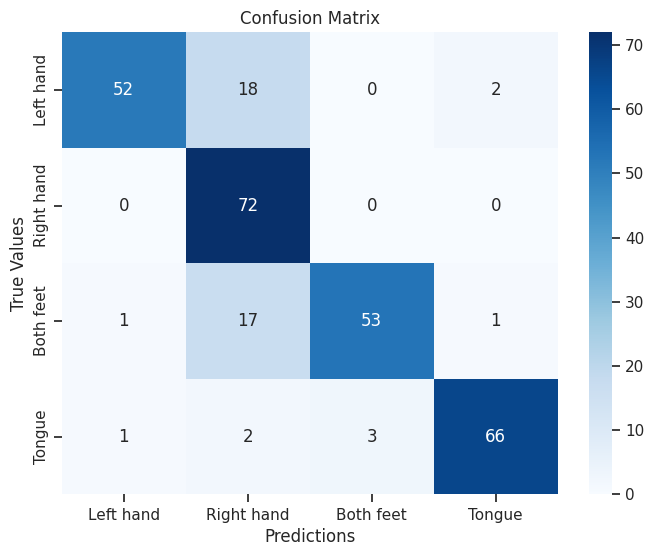

In [37]:
y_pred = ATCNet_model.predict(X_test)
evaluate_classification_metrics(y_test_onehot, y_pred)

We can see that our model doesn't perform as well as ATCNet. This is partly due to a reason. A signal can be represented in two different domains: either in the time domain or in the frequency domain. In this case, we have implemented the spectral transformer, which operates only in the frequency domain of the signal. In the original paper, an ensemble of a spectral transformer and a temporal transformer was implemented to capture information from both domains. In the case of ATCNet, it already incorporates a layer in the architecture that captures temporal information. Therefore, by only capturing information from the frequency domain with the spectral transformer, we may be missing relevant information in the time domain.


### Fine-Tuning

Finally, after developing the Spectral Transformer and comparing it with a state-of-the-art model to assess its performance, we will study the feasibility of using this model to classify signals in subjects with a high degree of uncertainty due to data sparsity. As we are in a low-data environment, we will first perform a general training with data from all subjects simultaneously. In this way, we attempt to make the model learn a general representation of EEG data. Once the model has learned the representation of the data in a general way, we will make it learn the characteristics for a specific subject and specialize.

**Note:** Despite training the model with all the data, we have no possible way to verify that the model has learned the general representation of the data, as the data from one subject to another are quite different. We hope that the model is able to learn, even to a lesser extent, the general distribution that EEG signals usually follow.


In [10]:
# Load standarized data
X_train_reshaped_std, y_train, X_test_reshaped_std, y_test = split_eeg_data(standardize=True)
X_train_psd = np.transpose(calculate_psd(X_train_reshaped_std), (0, 2, 1))
X_test_psd = np.transpose(calculate_psd(X_test_reshaped_std), (0, 2, 1))
y_train_onehot = np.eye(2)[y_train]
y_test_onehot = np.eye(2)[y_test]

100%|██████████| 475/475 [00:07<00:00, 65.96it/s]


In [11]:
# Obtener las dimensiones de los datos PSD
n_samples = X_train_psd.shape[1]
n_channels = X_train_psd.shape[2]

In [40]:
SpectralTransformer = create_spectral_transformer_model(n_samples, n_channels, num_stacked_transformers=1)
SpectralTransformer.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0009), metrics=['accuracy'])  
# Entrenar el modelo
SpectralTransformer.fit(X_train_psd,  # Datos de entrenamiento
                        y_train_onehot,        # Etiquetas de entrenamiento
                        epochs=500,            # Número de épocas de entrenamiento
                        batch_size=64,         # Tamaño del lote
                        validation_data=(X_test_psd, y_test_onehot))  # Datos de validación


Epoch 1/500
67/67 [==============================] - 3s 20ms/step - loss: 1.5141 - accuracy: 0.4951 - val_loss: 1.4321 - val_accuracy: 0.5305
Epoch 2/500
67/67 [==============================] - 1s 15ms/step - loss: 1.3876 - accuracy: 0.5009 - val_loss: 1.3280 - val_accuracy: 0.5053
Epoch 3/500
67/67 [==============================] - 1s 15ms/step - loss: 1.2850 - accuracy: 0.4995 - val_loss: 1.2309 - val_accuracy: 0.5474
Epoch 4/500
67/67 [==============================] - 1s 15ms/step - loss: 1.2018 - accuracy: 0.5241 - val_loss: 1.1681 - val_accuracy: 0.5368
Epoch 5/500
67/67 [==============================] - 1s 15ms/step - loss: 1.1295 - accuracy: 0.5215 - val_loss: 1.1011 - val_accuracy: 0.5453
Epoch 6/500
67/67 [==============================] - 1s 15ms/step - loss: 1.0705 - accuracy: 0.5309 - val_loss: 1.0527 - val_accuracy: 0.5053
Epoch 7/500
67/67 [==============================] - 1s 15ms/step - loss: 1.0183 - accuracy: 0.5344 - val_loss: 0.9980 - val_accuracy: 0.5747
Epoch 

In [14]:
epochs_train, all_labels = extract_motor_imagery_data(id_bad_subject)
all_data = epochs_train.get_data()

In [15]:
# Reshape the data for standardization
flattened_data = all_data.reshape((-1, 161))

# Calculate mean and standard deviation along the rows
mean_values = np.mean(flattened_data, axis=0)
std_values = np.std(flattened_data, axis=0)

# Apply z-score standardization
standardized_data = (flattened_data - mean_values) / std_values

# Reshape back to the original shape
all_data = standardized_data.reshape(all_data.shape)

In [16]:
# Reshape the data to have shape (4747, -1)
all_data_reshaped = all_data.reshape((all_data.shape[0], -1))

# Split into training and testing sets
X_train_reshaped, X_test_reshaped, y_train, y_test = train_test_split(
    all_data_reshaped, all_labels, test_size=0.1, random_state=42
    )

# Reshape de X_train y X_test al formato original
X_train_reshaped_std = X_train_reshaped.reshape((X_train_reshaped.shape[0], 64, 161))
X_test_reshaped_std = X_test_reshaped.reshape((X_test_reshaped.shape[0], 64, 161))


In [17]:
X_train_psd = np.transpose(calculate_psd(X_train_reshaped_std), (0, 2, 1))
X_test_psd = np.transpose(calculate_psd(X_test_reshaped_std), (0, 2, 1))
y_train_onehot = np.eye(2)[y_train]
y_test_onehot = np.eye(2)[y_test]

100%|██████████| 5/5 [00:00<00:00, 63.97it/s]


In [18]:
# Obtener las dimensiones de los datos PSD
n_samples = X_train_psd.shape[1]
n_channels = X_train_psd.shape[2]

In [19]:
SpectralTransformer.compile(loss='categorical_crossentropy', 
                            optimizer=Adam(learning_rate=0.001), 
                            metrics=['accuracy'])  
SpectralTransformer.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 129, 64)]         0         
                                                                 
 spectral_transformer (Spect  (None, 2)                290722    
 ralTransformer)                                                 
                                                                 
Total params: 290,722
Trainable params: 290,722
Non-trainable params: 0
_________________________________________________________________


In [20]:
SpectralTransformer.fit(X_train_psd, y_train_onehot, 
                        validation_data=(X_test_psd, y_test_onehot), 
                        epochs=5,
                        batch_size=64)

Epoch 1/5


1/1 [==============================] - 4s 4s/step - loss: 1.4105 - accuracy: 0.5000 - val_loss: 1.3894 - val_accuracy: 0.6000
Epoch 2/5
1/1 [==============================] - 1s 541ms/step - loss: 1.3992 - accuracy: 0.5250 - val_loss: 1.4081 - val_accuracy: 0.6000
Epoch 3/5
1/1 [==============================] - 1s 520ms/step - loss: 1.3936 - accuracy: 0.5250 - val_loss: 1.4120 - val_accuracy: 0.4000
Epoch 4/5
1/1 [==============================] - 0s 495ms/step - loss: 1.3851 - accuracy: 0.5750 - val_loss: 1.3773 - val_accuracy: 0.8000
Epoch 5/5
1/1 [==============================] - 0s 478ms/step - loss: 1.3657 - accuracy: 0.6000 - val_loss: 1.3733 - val_accuracy: 0.8000


1/1 [==============================] - 0s 414ms/step
Accuracy: 0.8
Precision: 0.8666666666666666
Recall: 0.8
F1 Score: 0.8


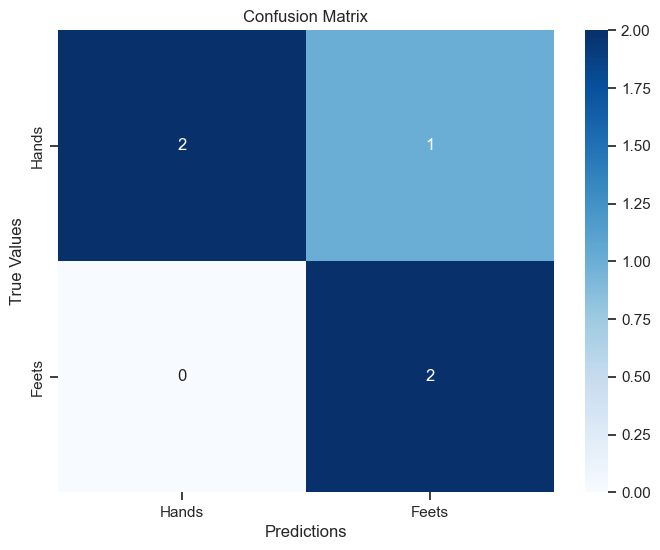

In [21]:
y_pred = SpectralTransformer.predict(X_test_psd)
evaluate_classification_metrics(y_test_onehot, y_pred, class_labels=['Hands', 'Feets'])